In [1]:
#### import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171535 entries, 0 to 171534
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171261 non-null  object 
 1   song                      171535 non-null  object 
 2   text                      171535 non-null  object 
 3   emotion                   171535 non-null  object 
 4   Genre                     171535 non-null  object 
 5   Tempo                     171535 non-null  int64  
 6   Loudness (db)             171535 non-null  float64
 7   Energy                    171535 non-null  int64  
 8   Danceability              171535 non-null  int64  
 9   Positiveness              171535 non-null  int64  
 10  Speechiness               171535 non-null  int64  
 11  Liveness                  171535 non-null  int64  
 12  Acousticness              171535 non-null  int64  
 13  Instrumentalness          171535 non-null  i

In [4]:
data['Artist(s)'].isnull().sum()

np.int64(274)

In [5]:
data.dropna(inplace=True)
data.reset_index(drop = True, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171261 entries, 0 to 171260
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171261 non-null  object 
 1   song                      171261 non-null  object 
 2   text                      171261 non-null  object 
 3   emotion                   171261 non-null  object 
 4   Genre                     171261 non-null  object 
 5   Tempo                     171261 non-null  int64  
 6   Loudness (db)             171261 non-null  float64
 7   Energy                    171261 non-null  int64  
 8   Danceability              171261 non-null  int64  
 9   Positiveness              171261 non-null  int64  
 10  Speechiness               171261 non-null  int64  
 11  Liveness                  171261 non-null  int64  
 12  Acousticness              171261 non-null  int64  
 13  Instrumentalness          171261 non-null  i

#### 4.2 **Power Transformer for Skewed Audio Features**

* we need to apply power transformer to the heavily skewed features like `instrumentalness`, `liveness`, `speechiness`, `loudness (db)` and `acousticness`.

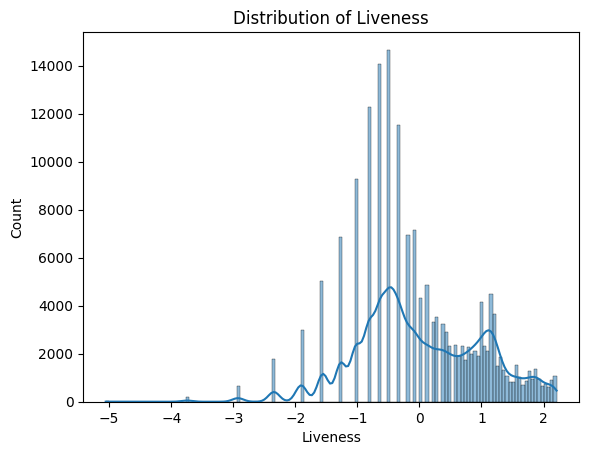

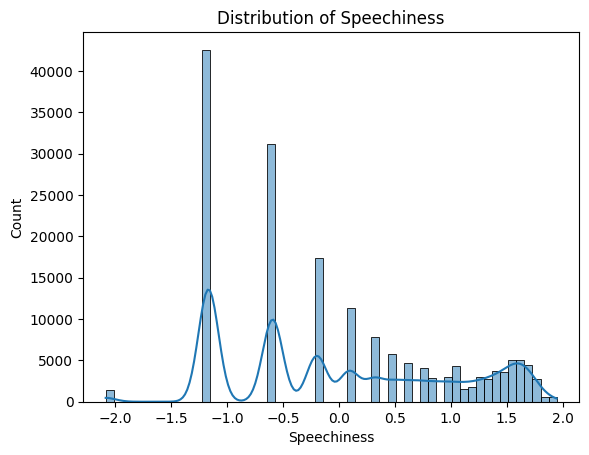

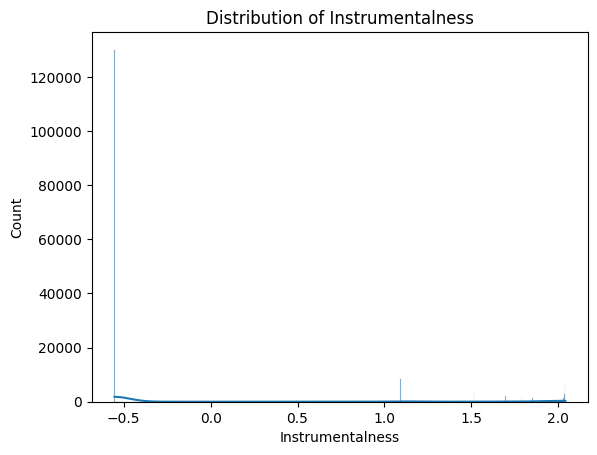

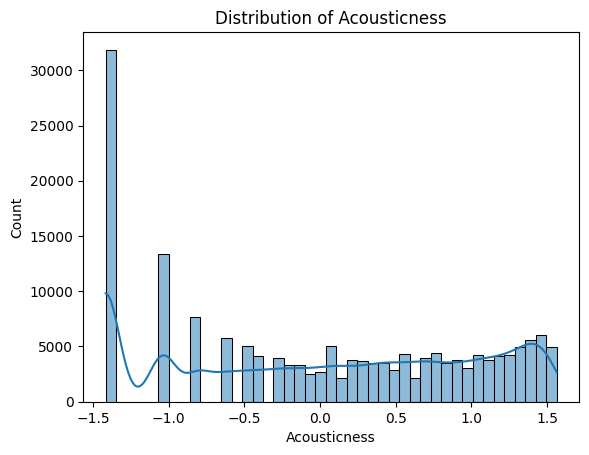

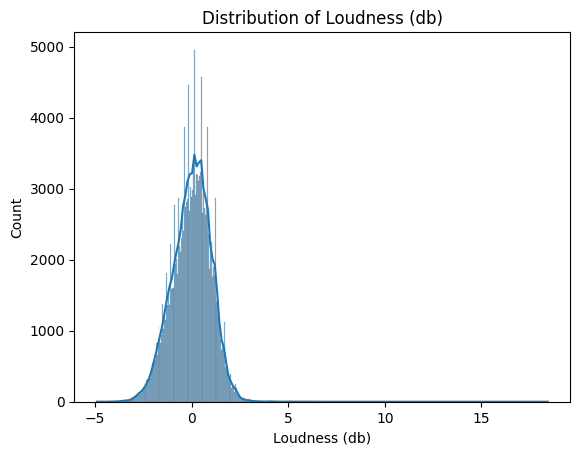

In [7]:
#### Applying power transformer to the skewed audio features.
pt = PowerTransformer(method='yeo-johnson')

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']

scaled_audio = pt.fit_transform(data[cols_to_transform])
data[cols_to_transform] = scaled_audio

cols_to_transform = ['Liveness', 'Speechiness', 'Instrumentalness', 'Acousticness', 'Loudness (db)']
for feature in cols_to_transform:
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

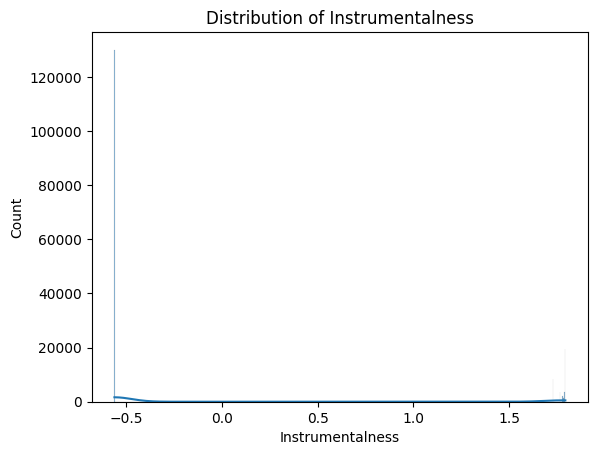

In [8]:
# apply log1p to instrumentalness first 
data[['Instrumentalness']] = np.log1p(data[['Instrumentalness']])

pt = PowerTransformer()
data[['Instrumentalness']] = pt.fit_transform(data[['Instrumentalness']])


sns.histplot(data['Instrumentalness'], kde=True)
plt.title(f'Distribution of Instrumentalness')
plt.show()

* Even after applying `log1p` and `power transformer` it doesn't change anything. so i will keep it as it is.

#### 4.3 **TF-IDF on text Columns**

In [9]:
### Converting genre column from list to string
import ast
data['Genre'] = data['Genre'].apply(ast.literal_eval)  

data['Genre_str'] = data['Genre'].apply(lambda x: ' '.join(x))

In [10]:
data['Genre_str'].head()

0    rock pop comedy
1    rock pop comedy
2    rock pop comedy
3    rock pop comedy
4    rock pop comedy
Name: Genre_str, dtype: object

In [11]:
data = data.drop('Genre', axis=1)

In [12]:
### Applying tf-idf on text columns 
data['combined_text'] = (
    data['text'] + " " +
    data['emotion'] + " " +
    data['Genre_str'] + " " +
    data['Artist(s)']
)

tfidf = TfidfVectorizer(max_features=300, stop_words='english') 
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

#### 4.4 **Combine TF-IDF & Scaled Audio features**

In [13]:
### Checking the shape od the tfidf matrix and scaled audio 
print(tfidf_matrix.shape[0], scaled_audio.shape[0]) 

171261 171261


In [14]:
from scipy.sparse import hstack

# Combine into one final feature set for cosine similarity
final_matrix = hstack([tfidf_matrix, scaled_audio])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171261 entries, 0 to 171260
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Artist(s)                 171261 non-null  object 
 1   song                      171261 non-null  object 
 2   text                      171261 non-null  object 
 3   emotion                   171261 non-null  object 
 4   Tempo                     171261 non-null  int64  
 5   Loudness (db)             171261 non-null  float64
 6   Energy                    171261 non-null  int64  
 7   Danceability              171261 non-null  int64  
 8   Positiveness              171261 non-null  int64  
 9   Speechiness               171261 non-null  float64
 10  Liveness                  171261 non-null  float64
 11  Acousticness              171261 non-null  float64
 12  Instrumentalness          171261 non-null  float64
 13  Good for Party            171261 non-null  i

#### **4.5 Handle User Query Input**

In [16]:
data['emotion'].unique()

array(['joy', 'anger', 'sadness', 'fear', 'surprise', 'love'],
      dtype=object)

In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Define allowed dataset moods
available_moods = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'love']

# Mapping user moods to dataset moods
mood_map = {
    'happy': 'joy',
    'calm': 'love',
    'relaxed': 'joy',
    'peaceful': 'joy',
    'romantic': 'love',
    'chill': 'joy',
    'energetic': 'surprise',
    'excited': 'surprise',
    'angry': 'anger',
    'depressed': 'sadness',
    'bored': 'sadness',
    'sad': 'sadness',
    'fearful': 'fear'
}

def extract_mood_artist_spacy(user_input, known_artists):
    doc = nlp(user_input.lower())

    # Extract mood using keyword matching and map it
    raw_moods = [token.text for token in doc if token.text in mood_map]
    mood = mood_map[raw_moods[0]] if raw_moods else ""

    # Extract artist
    artist = ""
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            for known_artist in known_artists:
                if known_artist in ent.text.lower():
                    artist = known_artist
                    break

    return mood, artist

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
known_artists = data['Artist(s)'].str.lower().unique().tolist()

user_input = "I'm feeling very chill broo, give me something from KK"
mood, artist = extract_mood_artist_spacy(user_input, known_artists)

print("Mapped mood:", mood)    
print("Artist:", artist) 

#### **5.Building Recommendation Logic Using Cosine Similarity**

In [ ]:
### Create Similar Artist Dictionary
from collections import defaultdict

# create song dict
song_similar_artist = defaultdict(list)
for idx, row in data.iterrows():
    base_song = row['song']
    for i in range(1, 4):
        sim_artist = row[f'Similar Artist {i}']
        if pd.notnull(sim_artist):
            song_similar_artist[base_song].append(sim_artist.strip().lower())

In [ ]:
### Create Similar Song Dictionary
similar_song = defaultdict(dict)

for idx, row in data.iterrows():
    base_song = row['song']
    for i in range(1,4):
        sim_song = row[f'Similar Song {i}']
        sim_score = row[f'Similarity Score {i}']
        if pd.notnull(sim_song):
            similar_song[base_song][sim_song] = sim_score

In [ ]:
similar_context_series = (
    data['Similar Artist 1']+ ' ' +
    data['Similar Artist 2']+ ' ' +
    data['Similar Artist 3']+ ' ' +
    data['Similar Song 1']+ ' ' +
    data['Similar Song 2']+ ' ' +
    data['Similar Song 3']
)

tfidf_similar = TfidfVectorizer(stop_words="english", max_features=5000)
similar_vectors = tfidf_similar.fit_transform(similar_context_series)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack


def get_recommendations(user_input, top_n=5):
    # Extract mood and artist using spaCy
    mood, artist = extract_mood_artist_spacy(user_input, known_artists)

    # Detect activity 
    activity_map = {
        "party": "Good for Party",
        "reading": "Good for Work/Study",
        "study": "Good for Work/Study",
        "exercise": "Good for Exercise",
        "running": "Good for Running",
        "driving": "Good for Driving",
        "morning": "Good for Morning Routine",
        "relaxation": "Good for Relaxation/Yoga",
        "yoga": "Good for Relaxation/Yoga",
        "meditation": "Good for Relaxation/Yoga"
    }

    activity_col = ""
    for key, col in activity_map.items():
        if key in user_input.lower():
            activity_col = col
            break

    # TF-IDF vector for mood + input text
    search_text = f"{mood} {user_input}" if mood else user_input
    mood_vector = tfidf.transform([search_text])

    # Combine with average audio vector
    avg_audio_vec = np.mean(scaled_audio, axis=0).reshape(1, -1)
    user_vector = hstack([mood_vector, avg_audio_vec])

    # Compute content-based similarity
    content_scores = cosine_similarity(user_vector, final_matrix).flatten()

    # Compute similar artist/song scores
    sim_context_input = artist if artist else mood
    sim_context_vector = tfidf_similar.transform([sim_context_input])
    sim_context_scores = cosine_similarity(sim_context_vector, similar_vectors).flatten()

    # Combine into final hybrid scores
    final_scores = 0.7 * content_scores + 0.3 * sim_context_scores

    # Apply optional activity column filter
    if activity_col:
        activity_mask = data[activity_col] == 1
        final_scores *= activity_mask.astype(int).values

    # Get top results
    top_indices = final_scores.argsort()[::-1][:top_n]
    results =  data.iloc[top_indices][['song', 'Artist(s)', 'emotion', 'Genre_str']].copy()

    # Add similar songs & artist from dictionaries
    similar_songs_set = set()
    similar_artists_set = set()

    for song in results['song']:
        similar_songs_set.update(similar_song.get(song, {}).keys())
        similar_artists_set.update(song_similar_artist.get(song, []))

        final_similar_songs = list(similar_songs_set)[:5]
        final_similar_artists = list(similar_artists_set)[:5]

    results['Similar Songs'] = final_similar_songs 
    results['Similar Artists'] = final_similar_artists 
    return results

In [ ]:
user_input = "I'm feeling very joy broo, give me something from KK"
get_recommendations(user_input)

* Instead of strictly relying on emotion labels (e.g., joy, sadness), similar songs are recommended based on lyrical similarity using TF-IDF and cosine similarity. This allows the system to capture songs whose lyrics align more closely with the user’s mood, even if the labeled emotion differs.